In [1]:
import numpy as np, pandas as pd, scipy as sp
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels as sm, os, nltk, string, re, operator
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection,preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, auc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
from collections import Counter
%matplotlib inline


### Phase 1 Cleaning

In [3]:
# Function to create dataframes 
def createDf(path,label):
    df = pd.DataFrame()
    for file in os.listdir(path):
        with open(os.path.join(path+file), errors='ignore') as f:
            df = df.append([{'label':label, 'reviews':f.read()}], ignore_index=True)
    return df

# Creating train and test dataframes with labels named pos as 1 and neg as 0    
trainDf = pd.concat([createDf("./aclImdb/train/pos/",1),createDf("./aclImdb/train/neg/",0)], ignore_index=True)
testDf = pd.concat([createDf("./aclImdb/test/pos3/",1),createDf("./aclImdb/test/neg3/",0)], ignore_index=True)
trainDf.shape, testDf.shape

((25000, 2), (25000, 2))

In [4]:
# Function to clean the data
from bs4 import BeautifulSoup
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english') + ['see','film','movie','one','story','character','make','time','even','youd','youll','youre','youve','actor','acting','actually']
#stopword = set(stopword) - set(['not','above','again','below','most','no','nor','very'])
wnl,ps = nltk.WordNetLemmatizer(),nltk.PorterStemmer()

def processData(txt):
    txt = BeautifulSoup(txt).get_text()            # Remove HTML Tags
    txt = "".join([char.lower() for char in txt if char not in string.punctuation]) # Remove punctuations
    txt = re.sub(r'\d+', '', txt)                  # To remove the numbers
    txt =  nltk.word_tokenize(txt)                 # Tokenizing
    txt = [word for word in txt if len(word)>2 and word not in stopword] # Removing stopswords and word length <3
    #txt = [ps.stem(word) for word in txt]        #Stemming
    txt = [wnl.lemmatize(word) for word in txt]   # Lemmatizing
    return txt

In [6]:
#Cleaning the data and saving to a new column
trainDf['cleaned'] = trainDf.reviews.apply(processData)
testDf['cleaned'] = testDf.reviews.apply(processData)

#Merging both datasets to a master dataframe for further use
masterDf = pd.concat([trainDf,testDf], ignore_index=True)
masterDf.shape

(50000, 3)

#### Extra Credits

In [0]:
#@title
# Function for feature selection 

def getFeature(df, number):
    
    featureList = []
    clf = ExtraTreesClassifier(n_estimators = 100)#, n_jobs=-1, random_state=2)
    cv = CountVectorizer(analyzer=processData, max_features=1000)
    x = cv.fit_transform(df['reviews'])
    y = df.label
    clf.fit(x, y)
    
    importances = clf.feature_importances_
    featureNames = cv.get_feature_names()
    featureimpDict = dict(zip(featureNames, importances))
    sortedFeatures = sorted(featureimpDict.items(), key=operator.itemgetter(1), reverse=True)
    
    for f in range(number):
        featureList.append(sortedFeatures[f][0])
    
    return featureList,sortedFeatures[:200]

In [0]:
#@title
#Applying feature slection to get most important words
features = getFeature(masterDf,10)
features[0], features[1][:15]

(['worst',
  'bad',
  'great',
  'waste',
  'excellent',
  'terrible',
  'awful',
  'boring',
  'worse',
  'poor'],
 [('worst', 0.021352900556114923),
  ('bad', 0.017563030082564327),
  ('great', 0.012500942992593389),
  ('waste', 0.010994130973561524),
  ('excellent', 0.008846473634191273),
  ('terrible', 0.008292270310555822),
  ('awful', 0.008119504992037249),
  ('boring', 0.006755340108671957),
  ('worse', 0.006376701489249556),
  ('poor', 0.00599097474124494),
  ('best', 0.005849053902842514),
  ('stupid', 0.005816668538509099),
  ('nothing', 0.005407145994545735),
  ('wonderful', 0.005101472227266177),
  ('horrible', 0.004662020804278741)])

In [8]:
masterDf['length'] = masterDf.reviews.apply(lambda x: len(x) - x.count(" "))
masterDf['clean'] = masterDf.cleaned.apply(lambda x: " ".join(x))
masterDf

,label,reviews,cleaned,length,clean
0,1,Bromwell High is a cartoon comedy. It ran at t...,"[bromwell, high, cartoon, comedy, ran, program...",667,bromwell high cartoon comedy ran program schoo...
1,1,Homelessness (or Houselessness as George Carli...,"[homelessness, houselessness, george, carlin, ...",1939,homelessness houselessness george carlin state...
2,1,Brilliant over-acting by Lesley Ann Warren. Be...,"[brilliant, overacting, lesley, ann, warren, b...",695,brilliant overacting lesley ann warren best dr...
3,1,This is easily the most underrated film inn th...,"[easily, underrated, inn, brook, cannon, sure,...",540,easily underrated inn brook cannon sure flawed...
4,1,This is not the typical Mel Brooks film. It wa...,"[typical, mel, brook, much, le, slapstick, mov...",528,typical mel brook much le slapstick movie plot...
...,...,...,...,...,...
49995,0,I occasionally let my kids watch this garbage ...,"[occasionally, let, kid, watch, garbage, under...",538,occasionally let kid watch garbage understand ...
49996,0,When all we have anymore is pretty much realit...,"[anymore, pretty, much, reality, show, people,...",715,anymore pretty much reality show people making...
49997,0,The basic genre is a thriller intercut with an...,"[basic, genre, thriller, intercut, uncomfortab...",1357,basic genre thriller intercut uncomfortable me...
49998,0,Four things intrigued me as to this film - fir...,"[four, thing, intrigued, firstly, star, carly,...",624,four thing intrigued firstly star carly pope p...


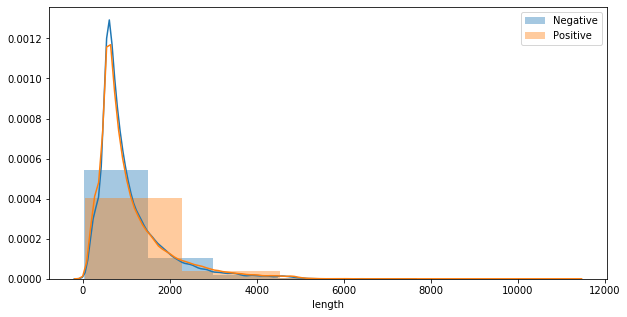

In [11]:
#@title
# To check whether the label is depended on the length of review
plt.figure(figsize=(10,5))
sns.distplot(masterDf[masterDf['label']==0]['length'], bins=5, label='Negative')
sns.distplot(masterDf[masterDf['label']==1]['length'], bins=5,   label='Positive')
plt.legend(loc='upper right')
plt.show()

Analysis 1

The length of the reviews doesn't appear to have much impact on the label. Eventhough negative reviews are little lengthier than positive reviews they can't be considered as a deciding factor. Some additional words were added to the stopwords list as it increased the accuracy and also the wordcloud presentation.

### Phase 2 Exploration

In [0]:
# Function to find most common words 

def wordFreq(label):
    words=[]
    for word in masterDf[masterDf.label==label].cleaned:
        words += word
    return nltk.FreqDist(words)

Most positive common words: [('like', 17540), ('good', 14419), ('great', 12694), ('get', 11096), ('well', 11070), ('really', 10676), ('also', 10553), ('would', 10368), ('scene', 9688), ('show', 9410), ('life', 9131), ('much', 8998), ('love', 8922), ('first', 8867), ('people', 8635), ('way', 8514), ('film', 8455), ('best', 8311), ('think', 7524), ('many', 7511)] 

Most negative common words: [('like', 22242), ('good', 14194), ('bad', 14091), ('would', 13633), ('get', 13335), ('really', 12222), ('scene', 11011), ('dont', 10010), ('much', 9897), ('people', 9341), ('thing', 9229), ('could', 9033), ('made', 8395), ('movie', 8354), ('plot', 8111), ('way', 8014), ('first', 7974), ('think', 7555), ('well', 7535), ('character', 7481)]


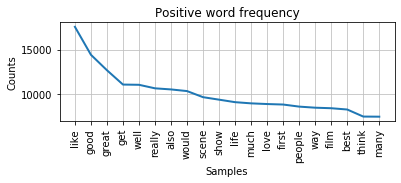

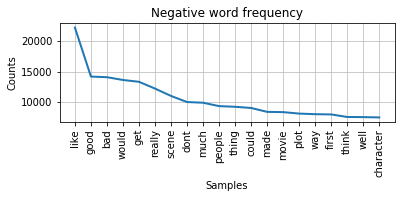

In [15]:
# Most common words associated with each category
posFreq = wordFreq(1)
negFreq = wordFreq(0)
print("Most positive common words:", posFreq.most_common(20), "\n\nMost negative common words:", negFreq.most_common(20))
#plt.figure(figsize=(16,10))
plt.subplot(211)
posFreq.plot(20,title='Positive word frequency')
#plt.figure(figsize=(16,10))
plt.subplot(212)
negFreq.plot(20,title='Negative word frequency')

In [16]:
# Lowest and highest frequency words
totFreq = posFreq+negFreq
print("Highest frequency words :", totFreq.most_common(10), "\n\nLowest Frequency words:", totFreq.most_common()[-10:])

Highest frequency words : [('like', 39782), ('good', 28613), ('get', 24431), ('would', 24001), ('really', 22898), ('scene', 20699), ('much', 18895), ('well', 18605), ('people', 17976), ('great', 17803)] 

Lowest Frequency words: [('clichã©landmine', 1), ('storyfinally', 1), ('asymmetric', 1), ('metaessay', 1), ('warnabys', 1), ('browfurrowingim', 1), ('secdonly', 1), ('rena', 1), ('bryces', 1), ('wagonthey', 1)]


#### Extra Credits

In [0]:
unsupDf = createDf("./aclImdb/train/unsup2/",1)
unsupDf.drop('label', axis=1, inplace=True)

In [13]:
unsupDf

,reviews
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."
...,...
49995,"Delightfully awful! Made by David Giancola, a ..."
49996,"Watching Time Chasers, it obvious that it was ..."
49997,At the beginning we can see members of Troma t...
49998,"The movie was incredible, ever since I saw it ..."


In [0]:
# Function to generate clusters
def cluster(df, num):

    tfiVect = TfidfVectorizer(analyzer=processData, max_features=3000, min_df=100)
    tfi = tfiVect.fit_transform(df.reviews)
    featureNames = tfiVect.get_feature_names()
    #print(featureNames)
    tfiNorm = preprocessing.normalize(tfi)
    tfiArray = tfiNorm.toarray()
    kmean = KMeans(n_clusters=num,  random_state=3, init='k-means++' , precompute_distances=True)
    kmean.fit(tfiArray)
    centers = kmean.cluster_centers_.argsort()[:,::-1]  
    for i in range(num):
      print("\nCluster %d:" %i)
      for j in centers[i, :10]:
        print("%s" %featureNames[j])
    #kmean.labels_
    #kmean.predict()
    return tfiVect,kmean

cluster(unsupDf, 2)


Cluster 0:
not
like
bad
good
really
dont
would
get
movie
people
very
thing
think
watch
scene

Cluster 1:
not
very
great
like
good
love
well
life
also
scene
film
show
get
best
most


(TfidfVectorizer(analyzer=<function processData at 0x7f8e338797b8>, binary=False,
                 decode_error='strict', dtype=<class 'numpy.float64'>,
                 encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                 max_features=3000, min_df=100, ngram_range=(1, 1), norm='l2',
                 preprocessor=None, smooth_idf=True, stop_words=None,
                 strip_accents=None, sublinear_tf=False,
                 token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                 vocabulary=None),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=2, n_init=10, n_jobs=None, precompute_distances=True,
        random_state=3, tol=0.0001, verbose=0))

Analysis 2

From the graphs above we can see that both positive and negative reviews are having many same high frequency words. In clustering the cluster 0 appears to have more negative reviews and cluster 1 with positive reviews

### Phase 3 Visualisation

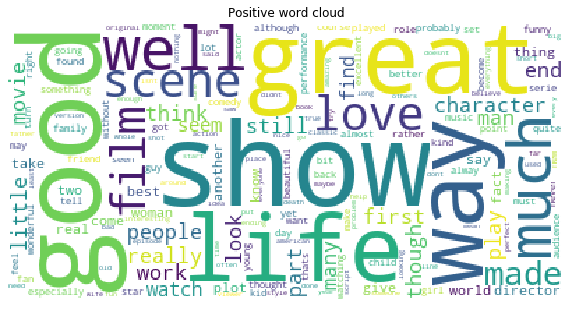

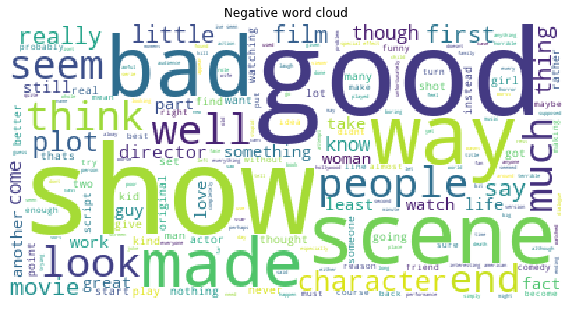

In [17]:
# Function to generate wordcloud
def wordCloud(lab,label): 
    if (label == 1) or (label == 0):
        text = ""
        for word in masterDf[masterDf.label==label].clean:
            text += word
    else:
        text = label    
    wc = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(10,8))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(lab+" word cloud")
    #return wc
    
wordCloud('Positive',1)
wordCloud('Negative',0)

In [0]:
#Converting the FreqDist() of dataset into seperate dataframes
poswordDf = pd.DataFrame(posFreq.most_common(200),columns=['word','counts'])
negwordDf = pd.DataFrame(negFreq.most_common(200),columns=['word','counts'])

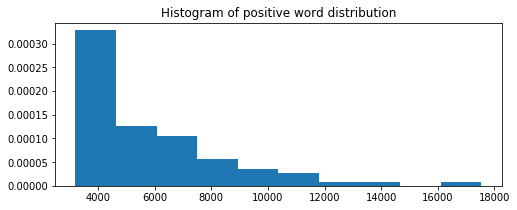

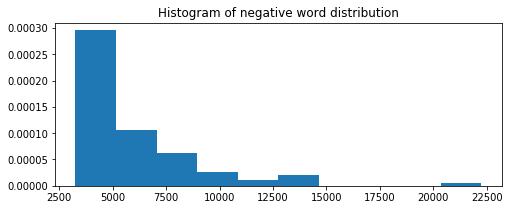

In [19]:
# Function to display histogram; typ 0 is nltk.FreqDist() and typ 1 is list

def wordHist(label,lab,typ):
    if typ==0:
        label = label 
    else:
        label = pd.DataFrame(label,columns=['word','counts'])
        
    plt.figure(figsize=(8,3))
    #plt.xlim(0,6000)
    plt.hist(label.counts[:100], bins=10, density=True)
    plt.title("Histogram of "+lab+" word distribution")
  
wordHist(poswordDf,'positive',0)
wordHist(negwordDf,'negative',0)

#plt.figure(figsize=(8,3))
#sns.distplot(posDist.counts[:100], label='Positive')
#sns.distplot(negDist.counts[:100], label='Negative')
#plt.legend(loc='upper right')

#### Extra Credits

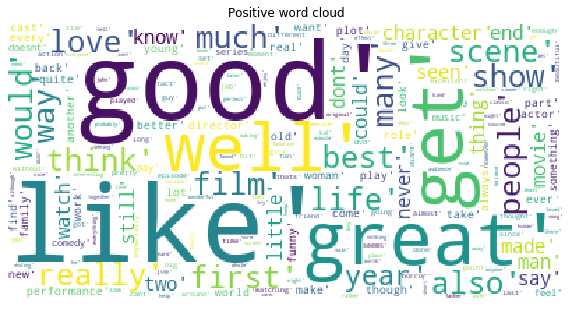

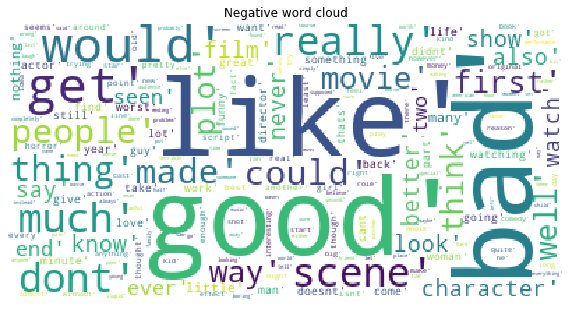

In [20]:
# Word cloud after feature selection. The features saved in the dataframe created above is passed to the wordcloud

wordCloud('Positive',(str(poswordDf.word.values)))
wordCloud('Negative',(str(negwordDf.word.values)))

In [21]:
# To display the wordclouds side by side
"""
wcp = wordCloud('Positive',posf)
wcn = wordCloud('Negative',negf)
fig, (ax, ax2) = plt.subplots(1,2, figsize = (18,8))
ax.imshow(wcp)
ax.axis('off')
ax.set_title(' Positive Wordcloud', fontsize = 20)
ax2.imshow(wcn)
ax2.axis('off')
ax2.set_title('Negative Wordcloud', fontsize = 20)
plt.show()

"""

"\nwcp = wordCloud('Positive',posf)\nwcn = wordCloud('Negative',negf)\nfig, (ax, ax2) = plt.subplots(1,2, figsize = (18,8))\nax.imshow(wcp)\nax.axis('off')\nax.set_title(' Positive Wordcloud', fontsize = 20)\nax2.imshow(wcn)\nax2.axis('off')\nax2.set_title('Negative Wordcloud', fontsize = 20)\nplt.show()\n\n"

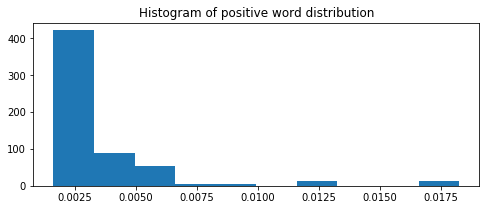

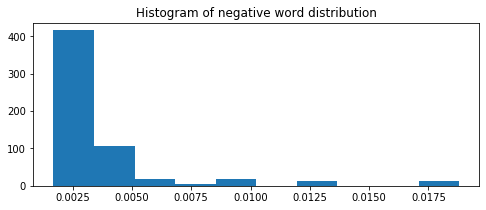

In [22]:
# Histogram of word distribution 
negf=getFeature(testDf,100)[1]
posf=getFeature(trainDf,100)[1]

wordHist(posf,'positive',1)
wordHist(negf,'negative',1)

### Analysis 3
Both positive and negative wordclouds have almost similar view with very few exceptions like word 'bad'. Nearly 90% of the words are distributed in the frequency range of 2k to 10k.
The two methods appear to have similar trends.

### Phase 4 Hypothesis testing  and Feature Selection

In [0]:
# Vectorising the train and test data
tf = TfidfVectorizer(analyzer=processData, max_features=4000)
xDf = tf.fit_transform(trainDf.reviews)
yDf = tf.transform(testDf.reviews)
xtfDf = pd.DataFrame(xDf.toarray(), columns=tf.get_feature_names())
ytfDf = pd.DataFrame(yDf.toarray(), columns=tf.get_feature_names())

#### Parametric Testing


In [0]:
# Function to build logistic regression model

import warnings
warnings.filterwarnings("ignore")
def logreg(xDf,yDf):
    lr = LogisticRegression()
    param = {'C': [0.01, 0.05, 0.25, 0.5, 1,0.001,.75]}
    gs = GridSearchCV(lr, param, cv=5, n_jobs=-1)
    gsfit = gs.fit(xDf, trainDf.label)
    pd.DataFrame(gsfit.cv_results_).sort_values('mean_test_score', ascending=False).head()
    ypred = gsfit.predict(yDf)
    print("Classification report of Logistic Regression:\n",classification_report(testDf.label,ypred))
    print("Accuracy of Logistic Regression:", round(accuracy_score(testDf.label,ypred),2))

logreg(xtfDf,ytfDf)

Classification report of Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy of Logistic Regression: 0.88


#### Non Parametric Testing


In [0]:
def knn(xDf,yDf):
    knn = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)
    knn.fit(xDf, trainDf.label)
    ypred = knn.predict(yDf)
    print("Classification report of KNeighborsClassifier:\n",classification_report(testDf.label,ypred))
    print("Accuracy of KNeighborsClassifier:", round(accuracy_score(testDf.label,ypred),2))

knn(xtfDf,ytfDf)

Classification report of KNeighborsClassifier:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76     12500
           1       0.75      0.77      0.76     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000

Accuracy of KNeighborsClassifier: 0.76


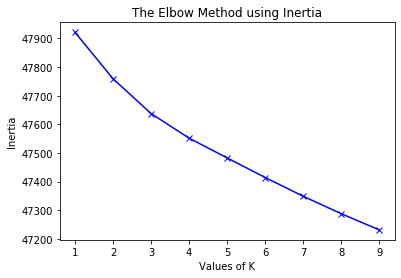

In [0]:
# Elbow plot to find the value of k for KMeans Clustering

tfiVect = TfidfVectorizer(analyzer=processData, max_features=3000, min_df=100)
unsuptf = tfiVect.fit_transform(unsupDf.reviews)
unsuptf = unsuptf.toarray()
iner = []
for k in range(1,10):
    kmean = KMeans(n_clusters=k, random_state=2, precompute_distances=True)
    kmean.fit(unsuptf)
    iner.append(kmean.inertia_)
K = range(1,10)
plt.plot(K, iner, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()


Analysis 4

Parametric logistic regression with gridsearch is giving an accuracy of 0.88 which means it is good model. Nonparametric KNeighborsClassifier is having lower accuracy of 0.76. From the elbow plot we can't find a steep variation to determine the value of K. Still at point 3 there is a narrow steep and hence it may be taken as K value

### Phase 5 Model Building

#### Supervised Learning

In [0]:
# Function to build SVM model
import warnings
warnings.filterwarnings("ignore")
def svc(xDf,yDf):
    sv = LinearSVC()
    param = {'C': [0.01, 0.05, 0.25, 0.5, 1,0.001,.75]}
    gs = GridSearchCV(sv, param, cv=5, n_jobs=-1)
    gsfit = gs.fit(xDf, trainDf.label)
    pd.DataFrame(gsfit.cv_results_).sort_values('mean_test_score', ascending=False).head()
    ypred = gsfit.predict(yDf)
    print("Classification report of SVM:\n",classification_report(testDf.label,ypred))
    print("Accuracy of SVC Classification:",round(accuracy_score(testDf.label,ypred),2))
  
svc(xtfDf,ytfDf)

Classification report of SVM:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy of SVC Classification: 0.88


#### Unsupervised Learning

In [0]:
# Calling the cluster function created earlier 
cluster(unsupDf, 2)


Cluster 0:
not
very
life
great
love
scene
film
also
like
best

Cluster 1:
not
like
good
really
very
would
movie
get
bad
think


(TfidfVectorizer(analyzer=<function processData at 0x7f8e338797b8>, binary=False,
                 decode_error='strict', dtype=<class 'numpy.float64'>,
                 encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                 max_features=2000, min_df=1, ngram_range=(1, 1), norm='l2',
                 preprocessor=None, smooth_idf=True, stop_words=None,
                 strip_accents=None, sublinear_tf=False,
                 token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                 vocabulary=None),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=0, tol=0.0001, verbose=0))

#### Extra Credits

##### EC1. Supervised Learning

In [0]:
# Function to build random forest classification model
def ranfor(xDf,yDf):
    rf = RandomForestClassifier()
    param = {'n_estimators': [300]}
    gs = GridSearchCV(rf, param, cv=6, n_jobs=-1)
    gsfit = gs.fit(xDf, trainDf.label)
    pd.DataFrame(gsfit.cv_results_).sort_values('mean_test_score', ascending=False).head()
    ypred = gsfit.predict(yDf)
    print("Classification report of Random forest:\n",classification_report(testDf.label,ypred))
    print("Accuracy of Random Forest:",accuracy_score(testDf.label,ypred))#round(accuracy_score(testDf.label,ypred),2))

In [0]:
# Function to build Multinominal Naive Bayes
def mnb(xDf,yDf):
    mnb = MultinomialNB()
    mnb.fit(xDf,trainDf.label)
    ypred = mnb.predict(yDf)
    print("Classification report of MNaive Bayes:\n",classification_report(testDf.label,ypred))
    print("Accuracy of MNB Classification:",accuracy_score(testDf.label,ypred))#round(accuracy_score(testDf.label,ypred),2))

In [0]:
print("With Tfid Vectoriser ")
ranfor(xtfDf,ytfDf)
svc(xtfDf,ytfDf)
mnb(xtfDf,ytfDf) 

With Tfid Vectoriser 
Classification report of Random forest:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Accuracy of Random Forest: 0.84808
Classification report of SVM:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy of SVC Classification: 0.88
Classification report of MNaive Bayes:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.

##### EC2. Unsupervised Learning

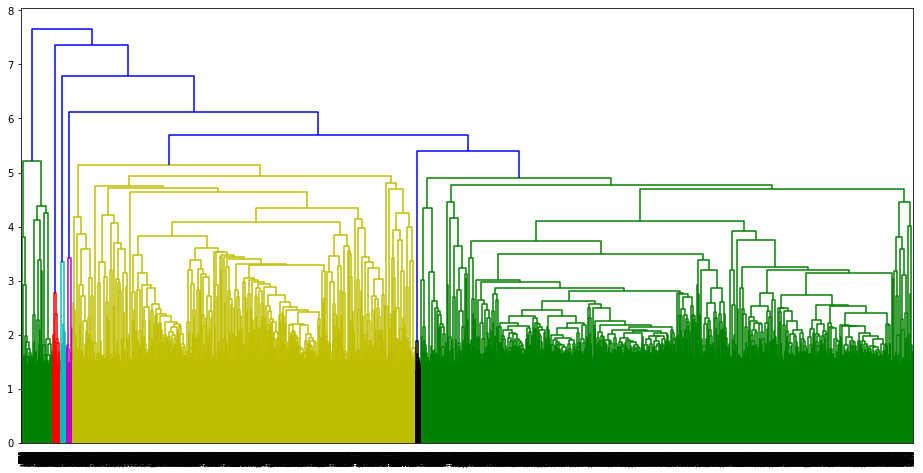

In [0]:
# Due to the time complexity of hierarchical cluster and memory issues, the model was build based on 50% of the dataset
plt.figure(figsize=(16,8))
dendrogram(linkage(unsuptf, method='ward'))

In [21]:
#Checking the performance of different clustering models
acmean = AgglomerativeClustering(n_clusters=2)
acmean.fit_predict(unsuptf)
Counter(acmean.labels_)

Counter({0: 23810, 1: 1190})

In [19]:
mini = MiniBatchKMeans(n_clusters=2, random_state=0).fit_predict(unsuptf)
Counter(mini)

Counter({0: 9718, 1: 15282})

In [20]:
sc = SpectralClustering(n_clusters=2, random_state=0).fit_predict(unsuptf)
Counter(sc)

Counter({0: 15501, 1: 9499})

##### EC 3. Labelling 4 clusters

In [0]:
# Calling cluster fucntion for different clusters to find labels
cluster(unsupDf, 6)


Cluster 0:
not
life
love
like
film
year
most
scene
man
best

Cluster 1:
bad
not
worst
acting
movie
ever
like
seen
good
dont

Cluster 2:
not
like
get
would
really
people
scene
much
dont
thing

Cluster 3:
show
episode
series
season
not
like
watch
would
really
great

Cluster 4:
book
read
not
novel
like
would
very
good
version
character

Cluster 5:
very
great
good
not
really
well
like
also
actor
movie


(TfidfVectorizer(analyzer=<function processData at 0x7ff4d3281510>, binary=False,
                 decode_error='strict', dtype=<class 'numpy.float64'>,
                 encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                 max_features=1000, min_df=1, ngram_range=(1, 1), norm='l2',
                 preprocessor=None, smooth_idf=True, stop_words=None,
                 strip_accents=None, sublinear_tf=False,
                 token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                 vocabulary=None),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=0, tol=0.0001, verbose=0))

In [0]:
# Generating 4 clusters
cluster(unsupDf, 4)


Cluster 0:
bad
not
worst
acting
movie
ever
like
good
seen
watch

Cluster 1:
not
like
really
get
good
would
people
very
scene
much

Cluster 2:
not
great
very
good
love
life
well
best
also
film

Cluster 3:
show
episode
series
season
not
like
watch
would
great
good


(TfidfVectorizer(analyzer=<function processData at 0x7ff4d3281510>, binary=False,
                 decode_error='strict', dtype=<class 'numpy.float64'>,
                 encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                 max_features=1000, min_df=1, ngram_range=(1, 1), norm='l2',
                 preprocessor=None, smooth_idf=True, stop_words=None,
                 strip_accents=None, sublinear_tf=False,
                 token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                 vocabulary=None),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=0, tol=0.0001, verbose=0))

After performing multiple clustering and analysis, dividing the dataset into 4 clusters is giving the better result. The labels are

**Cluster 0 as Negative reviews**

**Cluster 1 as Average reviews**

**Cluster 2 as Good reviews**

**Cluster 4 as Film series or TV programs**

since it contain words like 'show','episode','series','season' etc.

##### EC 4. Active Learning
Active Learning: Cluster the training dataset and try and find the genre. Manually annotate the cluster and then try to find the labels in the new testing dataset.

In [0]:
# Calling cluster function to find genres and saving the returned parameters for prediction                          
terms = cluster(trainDf,10)
tfiVect = terms[0]
kmean = terms[1]


Cluster 0:
book
read
novel
not
version
jane
like
would
good
adaptation

Cluster 1:
not
great
best
like
most
film
scene
performance
year
would

Cluster 2:
bad
worst
not
ever
movie
like
seen
good
dont
really

Cluster 3:
not
like
would
get
really
dont
people
scene
know
thing

Cluster 4:
funny
comedy
not
laugh
joke
like
good
really
very
great

Cluster 5:
horror
zombie
not
like
gore
film
good
movie
really
get

Cluster 6:
show
episode
season
not
like
would
really
watch
people
good

Cluster 7:
series
episode
season
show
first
not
like
good
original
great

Cluster 8:
life
not
woman
family
man
young
love
father
very
get

Cluster 9:
very
good
not
great
really
well
like
movie
also
much


(TfidfVectorizer(analyzer=<function processData at 0x7f8e338797b8>, binary=False,
                 decode_error='strict', dtype=<class 'numpy.float64'>,
                 encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                 max_features=3000, min_df=100, ngram_range=(1, 1), norm='l2',
                 preprocessor=None, smooth_idf=True, stop_words=None,
                 strip_accents=None, sublinear_tf=False,
                 token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                 vocabulary=None),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=10, n_init=10, n_jobs=None, precompute_distances=True,
        random_state=3, tol=0.0001, verbose=0))

In [0]:
# The clusters can be labelled as below
genre = {0:'Flim Adaptation', 6:'TV Programs', 2:'Flop', 3:'Documentary', 1: 'Romance', 4:'Comedy', 5:'Horror', 9:'Drama', 8:'Family', 7:'Film Franchise' }
genre

{0: 'Flim Adaptation',
 1: 'Romance',
 2: 'Flop',
 3: 'Documentary',
 4: 'Comedy',
 5: 'Horror',
 6: 'TV Programs',
 7: 'Film Franchise',
 8: 'Family',
 9: 'Drama'}

In [0]:
# Making the prediction on test data and creating new labels
tftest = tfiVect.transform(testDf.reviews)
tfiNorm = preprocessing.normalize(tftest)
ypred = kmean.predict(tfiNorm.toarray())
testDf['Genre'] = ypred
testDf['Genre'] = testDf.Genre.map(genre)
testDf[['label','reviews','Genre']]

,label,reviews,Genre
0,1,I went and saw this movie last night after bei...,Drama
1,1,Actor turned director Bill Paxton follows up h...,Family
2,1,As a recreational golfer with some knowledge o...,Family
3,1,"I saw this film in a sneak preview, and it is ...",Drama
4,1,Bill Paxton has taken the true story of the 19...,Romance
...,...,...,...
24995,0,I occasionally let my kids watch this garbage ...,Romance
24996,0,When all we have anymore is pretty much realit...,Documentary
24997,0,The basic genre is a thriller intercut with an...,Drama
24998,0,Four things intrigued me as to this film - fir...,Drama


In [0]:
# The number of reviews in each genre
Counter(testDf.Genre)

Counter({'Comedy': 1522,
         'Documentary': 5214,
         'Drama': 2500,
         'Family': 2941,
         'Film Franchise': 611,
         'Flim Adaptation': 524,
         'Flop': 2188,
         'Horror': 1085,
         'Romance': 7582,
         'TV Programs': 833})

### Analysis 5
Among the various models tried logistic regression and SVM is giving the highest accuracy of 0.88. The precision and f1 scores are also good which means it is a good fit. 
In unsupervised learning MiniBatchKMeans clustering is giving the best result. Agglomerative clustering is appears to give very inaccurate results.
Memory is a challenge since the dataset is big and hence time consuming. Some elaborate analysis was not able to be carried out because of it.
Few movie genres from train reviews data were identified and was labelled in the test set. Still movies with multiple genres, missing genres etc couldn't be included.